# Projeto 01 - Análise de Linguagem Ofensiva no Twitter

<b>Grupo 04</b>
<ul>
    <li>xxx - xxx</li>
    <li>xxx - xxx</li>
    <li>João Manoel Lins - xxx</li>
</ul>

Este trabalho é baseado na tarefa OffensEval que acontecem no âmbito das competições anuais de Semântica Computacional - SEMEVAL, edições de 2019 e 2020.

Seguem links para consulta:

<a href=http://alt.qcri.org/semeval2019/> SemEval 2019</a>

<a href=https://competitions.codalab.org/competitions/20011> OffensEval 2019</a>

<img src="fig/OffensLanguage_cloud.png" width="400px">



A linguagem ofensiva é massivamente difundida nas mídias sociais. Os indivíduos freqüentemente se aproveitam do anonimato nas comunicações mediadas por computador, para se envolver em comportamentos, os quais não considerariam na vida real. Comunidades on-line, plataformas de mídia social e empresas de tecnologia têm investido fortemente em maneiras de lidar com linguagem ofensiva para evitar comportamentos abusivos nas mídias sociais.

Uma das estratégias mais eficazes para resolver esse problema é usar métodos computacionais para identificar ofensas, agressões e discursos de ódio no conteúdo gerado pelo usuário (por exemplo, postagens, comentários, microblogs etc.). Em Processamento de Linguagem Natural (PLN), considera-se esta uma aplicação de classificação textual (<i>Text Classification</i>)

## Objetivos

Neste projeto, são propostas duas abordagens para analisar discursos ofensivos em tweets:

(A) Subtarefa A - Identificação de Linguagem Ofensiva 

- (NOT) Not Offensive - o tweet ou texto NÃO contem ofensa ou profanidade.
- (OFF) Offensive - o tweet ou texto contem qualquer tipo de linguagem não-aceitável (ofensa ou profanidade) ou uma ofensa direcionada (velada ou direta).


(B) Subtarefa B: Categorização dos tipos de ofensa

- (TIN) Targeted Insult and Threats - o tweet contem um insulto ou ameaça a um indivíduo, um grupo ou outros.
- (UNT) Untargeted - o tweet contem insultos, palavrões, ou ofensas não-direcionadas.

## Datasets


<b> Dados de Treinamento (arquivo texto simples "olid-training-v1.0.tsv")</b>

Um conjunto com 13.240 tweets anotados com os seguintes dados:
- id do tweet 
- texto do tweet
- label para subtarefa A
- label para subtarefa B
- label para subtarefa C (desconsiderar)

Exemplo:

<table>
    <thead> 
        <tr>
            <th><b>id</b></th>
            <th><b>tweet</b></th>
            <th><b>subtarefa A</b></th>
            <th><b>subtarefa B</b></th>
            <th><b>subtarefa C</b></th>
        </tr> 
    </thead>
    <tbody> 
        <tr>
            <td>90194</td>
            <td>@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL</td>
            <td>OFF</td>
            <td>TIN</td>
            <td>IND</td>
        </tr> 
        <tr>
            <td>16820</td>
            <td>Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT</td>
            <td>NOT</td>
            <td>NULL</td>
            <td>NULL</td>
        </tr>
    </tbody>
</table>


## Entregas

<b> ATIVIDADE 01 </b> - Pré-processamento dos textos (Prazo: 11/05/2020 - 30%)

- Tokenização
- Lematização
- POS Tagging
- Normalização (hashtags, menções, emojis e símbolos especiais)
- NER (entidades nomeadas)
- Remoção stop-words

<b> ATIVIDADE 02 </b> - Representação Semântica (Prazo: 22/06/2020 - 30%)

- Uso de bases de conhecimento externas
- Identificação de tópicos
- Representação vetorial das palavras e textos

<b> ATIVIDADE 03 </b> - Analise da Linguagem Ofensiva - Subtarefas A e B (Prazo: 27/07/2020 - 40%)

- Resultado da subtarefa A para um conjunto de teste a ser fornecido
- Resultado da subtarefa B para um conjunto de teste a ser fornecido



### Importação dos pacotes 

Necessário instalar o "en_core_web_lg" do spacy para classificar as entidades.

In [ ]:
!python -m spacy download en_core_web_lg

In [1]:
import warnings
import glob
import os
import re
from collections import defaultdict

import joblib
import pandas as pd
import numpy as np

import nltk
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer, TweetTokenizer

import spacy

from annoy import AnnoyIndex
import lmdb

from sklearn.base import clone
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

from joblib import dump, load

# Download Lemmatizer
nltk.download('wordnet')

# Download the pos tagger
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

# Download stopwords
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
nlp = spacy.load('en_core_web_lg')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joaomanoellins/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/joaomanoellins/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/joaomanoellins/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joaomanoellins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### GloVe - Word Embedding

In [26]:
from joblib import dump, load
GLOVE_FILENAME = 'glove.twitter.27B.200d.txt'
GLOVE_PATH = os.path.join(os.getcwd(), 'glove')
GLOVE_DATASET = os.path.join(GLOVE_PATH, GLOVE_FILENAME)

ANNOY_FILE = f'{GLOVE_FILENAME}.annoy'
ANNOY_PATH = os.path.join(GLOVE_PATH, ANNOY_FILE)

LMDB_FILE = f'{GLOVE_FILENAME}.lmdb'
LMDB_PATH = os.path.join(GLOVE_PATH, LMDB_FILE)

ARRAY_SIZE = 200

lmdb_env = None
annoy = AnnoyIndex(ARRAY_SIZE, 'angular')

# Método que recebe uma palavra, e retorna o word embedding
def get_glove_vector_by_name(name):
    try:
        with lmdb_env.begin() as txn:
            idx = int(txn.get(str(f'w{name}').encode())[1:])
            return np.array(annoy.get_item_vector(idx))
    except:
        return np.zeros(ARRAY_SIZE)

# Vai ler o arquivo glove treinado e salvar no annoy/lmdb
if (os.path.isfile(LMDB_PATH) or os.path.isfile(ANNOY_PATH)) is False:
    lmdb_env = lmdb.open(LMDB_PATH, map_size=int(1e9))

    with open(GLOVE_DATASET, 'r', encoding="utf-8") as file:
        with lmdb_env.begin(write=True) as txn:
            for idx, line in enumerate(file):
                try:
                    values = line.split()
                    word = values[0]
                    vector = np.asarray(values[1:], "float32")
                    # salvando no annoy
                    annoy.add_item(idx, vector)

                    # salvando no lmdb
                    idx = str(f'i{idx}').encode()
                    word = str(f'w{word}').encode()

                    txn.put(idx, word)
                    txn.put(word, idx)
                except:
                    pass
        annoy.build(200)
        annoy.save(ANNOY_PATH)
else: # se já tiver salvo, ler os arquivos
    annoy.load(ANNOY_PATH)
    lmdb_env = lmdb.open(LMDB_PATH, map_size=int(1e9))

### Carregar os tweets

In [47]:
DATASET_FOLDER = os.path.join(os.getcwd(), 'datasets')
DATASET_FILES = os.path.join(DATASET_FOLDER, '*.tsv')
file = glob.glob(DATASET_FILES)[0]
tweets = []

with open(file, 'r', encoding='utf-8') as f:
    # index começando de 1, pois:
    # a primeira linha que contem o cabeçalho vai ser ignorada.
    lines = f.readlines()[1:]
    for line in lines:
        # ignorando o subtask_c
        values = line.split('\t')
        tw_id = values[0]
        tw = values[1]
        stask_a = values[2]
        stask_b = values[3]
        
        tweets.append({
            'tweet': tw, 
            'subtask_a': stask_a, 'subtask_b': stask_b
        })

print(f'Quantidade total de tweets: {len(tweets)}')
print(tweets[0])

Quantidade total de tweets: 13240
{'tweet': '@USER She should ask a few native Americans what their take on this is.', 'subtask_a': 'OFF', 'subtask_b': 'UNT'}


### Normalizer

In [14]:
class TweetNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tknzr = TweetTokenizer()
        self.stopwords = nltk.corpus.stopwords.words('english')
        
        # https://stackoverflow.com/a/49146722/330558
        self.emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251""]+", flags=re.UNICODE)
        
        self.ltzr = WordNetLemmatizer()

    def is_stopword(self, token):
        return token is self.stopwords
    
    def is_emoji(self, token):
        return re.match(self.emoji_pattern, token)
    
    def pos_tag(self, tokens):
        return nltk.pos_tag(tokens)
    
    def lemmatize(self, token, tag):
        if tag.startswith('R'):
            return self.ltzr.lemmatize(token, pos='r')
        elif tag.startswith('J'):
            return self.ltzr.lemmatize(token, pos='a')
        elif tag.startswith('V'):
            return self.ltzr.lemmatize(token, pos='v')

        return self.ltzr.lemmatize(token)
    
    def normalize(self, tokens=[]):
        normalized_tokens = []
        normalized_tokens_lemma = []
        pos_tag = self.pos_tag(tokens)
        
        for idx, token in enumerate(tokens):
            # Ignora stop word
            if self.is_stopword(token): continue
                
            # Ignora emojis
            if self.is_emoji(token): continue
        
            token = token.lower()
    
            # Checa se a palavra começa com @ (mention)
            # Se tiver, será substituida pela tag forneciada em mention.
            token = re.sub(r'@[\w0-9_.]+', 'mention', token)

            # Checa se contem número. Se tiver, será ignorado.
            # Com isso será removido valores financeiros e datas.
            token = re.sub(r'^[0-9]+$', '', token)

            # Checa se contem uma risada. Se tiver, será ignorado.
            token = re.sub(r"[aeiou]*[h][haeuio]{3,}", 'laugh', token)

            # Remove caracteres especiais.
            # O caractere ' não é removido, pois é importante no inglês.
            token = re.sub(r'[^A-Za-z\@\#]+', '', token)
            
            # ignora token com caractere especial
            if token == '': continue
            
            # Cria o lemma do token, o pos_tag é uma tupla. 
            # Index 0 é a posição da tag na tupla.
            # Index 1 é a a palavra. Não utilizado.
            lemma = self.lemmatize(token, pos_tag[idx][0])
            
            normalized_tokens_lemma.append(lemma)
            normalized_tokens.append(token)
            
        # Retorna os tokens normalizados e lemmatizados
        return {
            'original_tweet': ' '.join(tokens),
            'lemmas': normalized_tokens_lemma,
            'normalized_tweet': normalized_tokens
        }
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, documents):
        for document in documents:
            tokens = self.tknzr.tokenize(document)
            yield self.normalize(tokens)

### Featurizer

In [104]:
class TweetFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tknzr = TweetTokenizer()
        self.lemmatizer = WordNetLemmatizer()
        self.tfidf_vec_uni = TfidfVectorizer(ngram_range=(1,1))
        self.tfidf_vec_bi = TfidfVectorizer(ngram_range=(2,2))
        self.normalized_tweets = []
        self.__X = []

    def fit(self, X, y=None):
        # saving the generator
        X = list(X)
        self.__X = X
        self.normalized_tweets = [' '.join(n_tweet['normalized_tweet']) for n_tweet in X]
        self.tfidf_vec_uni.fit(self.normalized_tweets)
        self.tfidf_vec_bi.fit(self.normalized_tweets)
        
        return self
    
    def feed_wordnet(self, word):
        l_word = self.lemmatizer.lemmatize(word)

        # Uma palavra por vez. [0] é para pegar a palavra.
        # [1] é para pegar a tag, pois é retornado uma tupla.
        l_pos = nltk.pos_tag([l_word], tagset='universal')[0][1]
        sys_pos = {
            'VERB': wn.VERB,
            'NOUN': wn.NOUN,
            'ADV': wn.ADV,
            'ADJ': wn.ADJ
        }
        
        try:
            sys = wn.synsets(word, sys_pos[l_pos])[0]
            lemma = sys.lemmas()[0]
            
            # Máximo de 10 Hipônimo/Hiperônimo 
            hypernyms = [lemma.name() for h in sys.hypernyms() for lemma in h.lemmas()][:10]
            hyponyms = [lemma.name() for h in sys.hyponyms() for lemma in h.lemmas()][:10]
            
            return {
                'hypernyms': hypernyms,
                'hyponyms': hyponyms
            }
        except:
            pass

    def transform(self, X, y=None):
        # TF-IDF - UNIGRAM
        tfidf_uni_values = self.tfidf_vec_uni.transform(self.normalized_tweets)
        
        # TF-IDF - BIGRAM
        tfidf_bi_values = self.tfidf_vec_bi.transform(self.normalized_tweets)
        
        for idx, tweet in enumerate(X):
            features = {
                'unigram': {'bow': defaultdict(int), 'tfidf': []},
                'bigram': {'bow': defaultdict(int), 'tfidf': []},
                'ner': {},
                'embedding': {},
                'pos': {},
                'wordnet': {}
            }
        
            normalized_tweet = ' '.join(tweet['normalized_tweet'])
            nlp_doc = nlp(normalized_tweet)
            for token in nlp_doc:
                word = re.sub(r'[^\w\s]','', token.text).lower()
                
                if word is not '':
                    # chamando a wordnet
                    features['wordnet'][word] = self.feed_wordnet(word)
                    
                    features['unigram']['bow'][word] += 1
                    features['pos'][word] = token.pos_
                    features['embedding'][word] = get_glove_vector_by_name(word)
                
                # Named Entity Recognition (Spacy)
                for ent in nlp_doc.ents:
                    features['ner'][ent.text] = ent.label_            
            # BIGRAM
            for gram in list(ngrams(self.tknzr.tokenize(self.normalized_tweets[idx]), 2)):
                word = ' '.join(str(g) for g in gram)
                word = re.sub(r'[^\w\s]', '', word.lower())
                features['bigram']['bow'][word] += 1
                
            features['unigram']['tfidf'] = tfidf_uni_values[idx].toarray()[0]
            features['bigram']['tfidf'] = tfidf_bi_values[idx].toarray()[0]
            
            yield {**features, **self.__X[idx]}

### Normalizando e Extraindo Features dos Tweets

In [ ]:
X = [t['tweet'] for t in tweets]
y = [0 if t['subtask_a'] == 'NOT' else 1 for t in tweets]

pipeline = Pipeline([
    ('normalize', TweetNormalizer()),
    ('featurize', TweetFeaturizer())
])

TWEETS_SAVED_PATH = os.path.join(os.getcwd(), 'tweets.sav')

_tweets = None

if os.path.isfile(TWEETS_SAVED_PATH):
    _tweets = joblib.load(TWEETS_SAVED_PATH)
else:
    _tweets = list(pipeline.fit_transform(X))
    joblib.dump(_tweets, TWEETS_SAVED_PATH)

---

## Mostrando Tweet - Normalizado/Caracterizado

A variável _tweets possui os tweets normalizados e suas características como Bag-of-Words, TF-IDF, Bigramas, Named-entity Recognition, Part of Speech, Base de Conhecimento (WordNet) e etc...

Vamos usar o tweet abaixo para demonstração:

<table>
    <thead> 
        <tr>
            <th><b>id</b></th>
            <th><b>tweet</b></th>
            <th><b>subtarefa A</b></th>
            <th><b>subtarefa B</b></th>
            <th><b>subtarefa C</b></th>
        </tr> 
    </thead>
    <tbody> 
        <tr>
            <td>90194</td>
            <td>@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL</td>
            <td>OFF</td>
            <td>TIN</td>
            <td>IND</td>
        </tr> 
    </tbody>
</table>

### Tweet Normalizado

In [7]:
' '.join(_tweets[1]['normalized_tweet'])

'mention mention go home you re drunk mention #maga #trump url'

### Unigrama

#### Bag-of-Words

In [8]:
_tweets[1]['unigram']['bow']

defaultdict(int,
            {'mention': 3,
             'go': 1,
             'home': 1,
             'you': 1,
             're': 1,
             'drunk': 1,
             'maga': 1,
             'trump': 1,
             'url': 1})

#### Tf-idf

In [9]:
_tweets[1]['unigram']['tfidf']

array([0., 0., 0., ..., 0., 0., 0.])

### Bigrama

#### Bag-of-Words

In [10]:
_tweets[1]['bigram']['bow']

defaultdict(int,
            {'mention mention': 1,
             'mention go': 1,
             'go home': 1,
             'home you': 1,
             'you re': 1,
             're drunk': 1,
             'drunk mention': 1,
             'mention maga': 1,
             'maga trump': 1,
             'trump url': 1})

### tf-idf

In [11]:
_tweets[1]['bigram']['tfidf']

array([0., 0., 0., ..., 0., 0., 0.])

### NER - Reconhecimento de Entidades Nomeadas 

In [12]:
_tweets[1]['ner']

{'maga': 'GPE'}

### Word Embedding

In [13]:
_tweets[1]['embedding']

{'mention': array([ 3.77730012e-01,  1.18040001e+00, -1.00390002e-01,  2.22090006e-01,
         4.81359996e-02, -5.62309980e-01,  6.07020020e-01,  2.10260004e-01,
        -9.11339968e-02, -1.24300003e-01,  2.17040002e-01, -7.75789976e-01,
         5.40160000e-01, -6.09600008e-01, -2.04699993e-01,  4.56519991e-01,
         3.54579985e-02, -1.13470003e-01, -5.81590012e-02, -1.92300007e-01,
         5.17019987e-01,  1.20350003e-01, -8.89930010e-01, -3.34969997e-01,
         1.96079999e-01,  2.45600000e-01,  1.78739995e-01, -4.79539990e-01,
         1.42049998e-01,  2.33879998e-01, -1.73040003e-01,  2.46700004e-01,
        -2.15409994e-01,  2.63099998e-01,  1.37219995e-01, -1.71869993e-01,
         1.14790000e-01,  2.37559993e-02,  3.74249995e-01,  4.06709999e-01,
        -9.95310009e-01,  5.00930011e-01, -2.15039998e-01,  3.34770009e-02,
         7.98280002e-04, -3.28579992e-01, -9.01220024e-01, -2.08930001e-01,
         5.20980000e-01, -1.58690006e-01,  2.39800006e-01,  3.18540007e-01,
 

### Part-of-Speech 

In [14]:
_tweets[1]['pos']

{'mention': 'NOUN',
 'go': 'VERB',
 'home': 'ADV',
 'you': 'PRON',
 're': 'VERB',
 'drunk': 'ADJ',
 'maga': 'PROPN',
 'trump': 'PROPN',
 'url': 'X'}

### Base de Conhecimentos

Hiperônimo é uma palavra que pertence ao mesmo campo semântico de outra mas com o sentido mais abrangente. Ex: Flor seria hiperônimo de rosa, dália, violeta.

Hipônimo têm sentido mais restrito que os hiperônimos, ou seja, hipônimo é um vocábulo mais específico. Por exemplo: Observar, examinar, olhar, enxergar são hipônimos de ver.

In [15]:
_tweets[1]['wordnet']

{'mention': {'hypernyms': ['remark', 'comment', 'input'],
  'hyponyms': ['allusion', 'name-dropping', 'retrospection']},
 'go': {'hypernyms': [],
  'hyponyms': ['accompany',
   'advance',
   'progress',
   'pass_on',
   'move_on',
   'march_on',
   'go_on',
   'angle',
   'ascend',
   'go_up']},
 'home': {'hypernyms': ['residence', 'abode'],
  'hyponyms': ['home_away_from_home', 'home_from_home']},
 'you': None,
 're': {'hypernyms': ['metallic_element', 'metal'], 'hyponyms': []},
 'drunk': {'hypernyms': ['drinker', 'imbiber', 'toper', 'juicer'],
  'hyponyms': ['alcoholic',
   'alky',
   'dipsomaniac',
   'boozer',
   'lush',
   'soaker',
   'souse']},
 'maga': None,
 'trump': {'hypernyms': ['playing_card'], 'hyponyms': []},
 'url': {'hypernyms': ['address', 'computer_address', 'reference'],
  'hyponyms': []}}

---

## Entrega 3

### Funções Auxiliadoras

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

pos_list = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ',
            'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 
            'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'POS', 'SPACE']
encoder = LabelBinarizer()
encoder.fit(pos_list)

def transform_embedding_column(X):
    # elevando por 2 para evitar negativos
    return [sum(x['embedding'].values()) ** 2 for x in X]

def transform_tfidf_column(X, col='unigram'):
    return list(map(lambda x: x[col]['tfidf'], X))


def transform_pos_column(X):
    return list(map(lambda x: np.sum(encoder.transform(list(set(x['pos'].values()))), axis=0), X))


def dataset_split(X):
    y_a = [0 if t['subtask_a'] == 'NOT' else 1 for t in tweets]
    y_b = [0 if t['subtask_b'] != 'TIN' else 1 for t in tweets]    

    return train_test_split(X, y_a, y_b, test_size=0.2, random_state=42)

### Testando os Classificadores - Feauture "embedding"

In [17]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = [
    ('MultinomialNB', MultinomialNB()),
    ('GaussianNB', GaussianNB()),
    ('LogisticRegression', LogisticRegression(n_jobs=-1)),
    ('SGDClassifier', SGDClassifier(n_jobs=-1)),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('RandomForestClassifier', RandomForestClassifier(n_jobs=-1)),
    ('KNeighborsClassifier', KNeighborsClassifier(n_jobs=-1)),
    ('SVC', SVC()),
    ('AdaBoost', AdaBoostClassifier())
]

steps = []
pipelines = []
df_algo_valuation = pd.DataFrame(columns=['Algoritmo', 'Tarefa_A', 'Tarefa_B'])

for name, model in models:
    steps_ = steps.copy()
    steps_.append((f'clf_{name}', model))
    df_algo_valuation = df_algo_valuation.append({'Algoritmo': name, 'Tarefa_A': 0, 'Tarefa_B': 0}, ignore_index=True)
    
    pipelines.append(Pipeline(steps_))

Só utilizando a feature "embedding"

In [51]:
%%time

X_train, X_test, ya_train, ya_test, yb_train, yb_test = dataset_split(_tweets)
X_train_transformed = transform_embedding_column(X_train)

# Tarefa A
for idx, pipeline in enumerate(pipelines):
    model_name = pipeline.steps[-1][0].replace('clf_', '')

    pipeline.fit(X_train_transformed, ya_train)
    predicts = pipeline.predict(transform_embedding_column(X_test))
    
    df_algo_valuation.at[idx, 'Tarefa_A'] = 100 * round(np.mean(predicts == ya_test), 2)
    
# Tarefa B
for idx, pipeline in enumerate(pipelines):
    model_name = pipeline.steps[-1][0].replace('clf_', '')

    pipeline.fit(X_train_transformed, yb_train)
    predicts = pipeline.predict(transform_embedding_column(X_test))
    
    df_algo_valuation.at[idx, 'Tarefa_B'] = 100 * round(np.mean(predicts == yb_test), 2)

CPU times: user 2min 17s, sys: 3.98 s, total: 2min 21s
Wall time: 2min


Os algoritmos tiveram um desempenho um pouco melhor na Tarefa B, utilizando apenas a feature "embedding".

In [52]:
df_algo_valuation.mean()

Tarefa_A    65.444444
Tarefa_B    67.777778
dtype: float64

### Resultado dos Algoritmos

In [53]:
df_algo_valuation.sort_values('Tarefa_A', ascending=False)

,Algoritmo,Tarefa_A,Tarefa_B
2,LogisticRegression,69,71
5,RandomForestClassifier,69,71
8,AdaBoost,69,71
3,SGDClassifier,67,70
0,MultinomialNB,66,68
7,SVC,65,70
6,KNeighborsClassifier,62,65
1,GaussianNB,61,62
4,DecisionTreeClassifier,61,62


Vamos continuar utilizando apenas os algoritmos LogisticRegression, AdaBoost, SGDClassifier e RandomForestClassifier. O restante será descartado.

----

## Fine-Tuning - GridSearch (Tarefa A)

### Logistic Regression

In [27]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Testando apenas hyperparameter dos classificadores
params = [
    {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__tol': [True, False],
        'classifier__max_iter': [100, 500, 1000],
        'classifier__tol': np.linspace(1e-5, 1, 5),
        'classifier__C': np.logspace(-4, 4, 5)
    }
]

steps = [
    ('classifier', LogisticRegression())
]

X_train, X_test, ya_train, ya_test, _, _ = dataset_split(_tweets)

clf = Pipeline(steps)
gs_clf = GridSearchCV(clf, params, cv=10, verbose=True, n_jobs=-1)
gs_clf.fit(transform_embedding_column(X_train), ya_train)

print(gs_clf.best_score_)
print(gs_clf.best_params_)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


KeyboardInterrupt: 

### SGDClassifier

In [ ]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

# Testando apenas hyperparameter dos classificadores
params = [
    {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__max_iter': [100, 500, 750, 1000, 1100, 1200],
        'classifier__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
        'classifier__loss': ['hinge', 'log']
    }
]

steps = [
    ('classifier', SGDClassifier())
]

X_train, X_test, ya_train, ya_test, _, _ = dataset_split(_tweets)

clf = Pipeline(steps)
gs_clf = GridSearchCV(clf, params, cv=10, verbose=True, n_jobs=-1)
gs_clf.fit(transform_embedding_column(X_train), ya_train)

print(gs_clf.best_score_)
print(gs_clf.best_params_)

### RandomForestClassifier

In [ ]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier

# Testando apenas hyperparameter dos classificadores
params = [
    {
        'classifier__n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 4)],
        'classifier__max_features': ['auto'],
        'classifier__max_depth': [int(x) for x in np.linspace(start = 10, stop = 30, num = 4)],
        'classifier__min_samples_leaf': [5, 10],
        'classifier__min_samples_split': [5, 10],
        'classifier__bootstrap': [True, False],
    }
]

steps = [
    ('classifier', RandomForestClassifier())
]

X_train, X_test, ya_train, ya_test, _, _ = dataset_split(_tweets)

clf = Pipeline(steps)
gs_clf = GridSearchCV(clf, params, cv=10, verbose=True, n_jobs=-1)
gs_clf.fit(transform_embedding_column(X_train), ya_train)

print(gs_clf.best_score_)
print(gs_clf.best_params_)

### AdaBoostClassifier

In [ ]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import AdaBoostClassifier

# Testando apenas hyperparameter dos classificadores
params = [
    {
        'classifier__n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        'classifier__learning_rate':[.001, 0.01, 0.05, .1]
    }
]

steps = [
    ('classifier', AdaBoostClassifier())
]

X_train, X_test, ya_train, ya_test, _, _ = dataset_split(_tweets)

clf = Pipeline(steps)
gs_clf = GridSearchCV(clf, params, cv=10, verbose=True, n_jobs=-1)
gs_clf.fit(transform_embedding_column(X_train), ya_train)

print(gs_clf.best_score_)
print(gs_clf.best_params_)

----

## Pontuação - Feauture Embedding

### Métricas

In [169]:
X = _tweets.copy()
y_a = [0 if t['subtask_a'] == 'NOT' else 1 for t in tweets]
y_b = [0 if t['subtask_b'] != 'TIN' else 1 for t in tweets]

X_train, X_test, ya_train, ya_test, yb_train, yb_test = dataset_split(X)
X_train_transformed = transform_embedding_column(X_train)
X_test_transformed = transform_embedding_column(X_test)

### Logistic Regression

In [175]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = LogisticRegression(
    C=100.0,
    max_iter=500,
    penalty='l2',
    tol=1e-05
)

clf_b = clone(clf_a)

In [176]:
print('Relatório de Classificação - LogisticRegression - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

ya_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, ya_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - LogisticRegression - Tarefa A
              precision    recall  f1-score   support

         NOT       0.71      0.90      0.79      1733
         OFF       0.62      0.31      0.41       915

    accuracy                           0.70      2648
   macro avg       0.67      0.60      0.60      2648
weighted avg       0.68      0.70      0.66      2648



In [177]:
print('Relatório de Classificação - LogisticRegression - Tarefa B')
clf_b.fit(X_train_transformed, yb_train)

yb_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, yb_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - LogisticRegression - Tarefa B
              precision    recall  f1-score   support

         UNT       0.73      0.92      0.82      1856
         TIN       0.53      0.21      0.30       792

    accuracy                           0.71      2648
   macro avg       0.63      0.57      0.56      2648
weighted avg       0.67      0.71      0.66      2648



Matriz de Confusão - LogisticRegression - Tarefa A


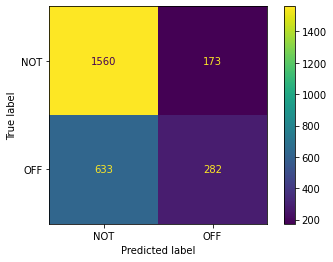

In [178]:
print('Matriz de Confusão - LogisticRegression - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - LogisticRegression - Tarefa B


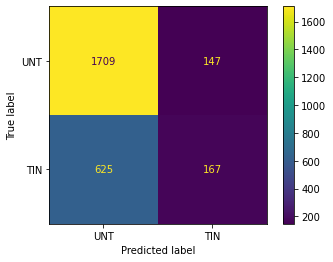

In [179]:
print('Matriz de Confusão - LogisticRegression - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - LogisticRegression- Tarefa A


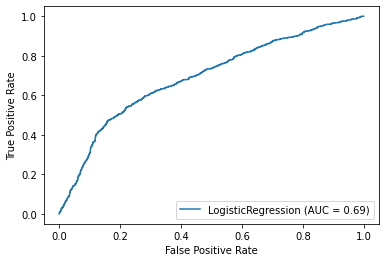

In [180]:
print('Curva ROC - LogisticRegression- Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - LogisticRegression - Tarefa B


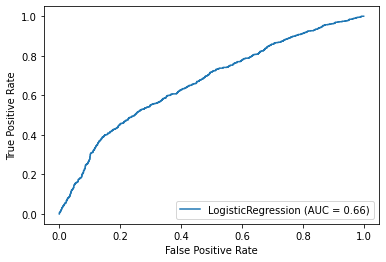

In [181]:
print('Curva ROC - LogisticRegression - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [182]:
scores = cross_val_score(clf_a, X_test_transformed, y_a, cv=10, n_jobs=-1)
print("Pontuação Média - LogisticRegression - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - LogisticRegression - Tarefa A - Cross Validation: 0.71 (+/- 0.02)


In [183]:
scores = cross_val_score(clf_b, X_test_transformed, y_b, cv=10, n_jobs=-1)
print("Pontuação Média - LogisticRegression - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - LogisticRegression - Tarefa B - Cross Validation: 0.73 (+/- 0.02)


---

### SGDClassifier

In [184]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = SGDClassifier(
    alpha=0.001,
    loss='hinge',
    max_iter=1000,
    penalty='l1'
)

clf_b = clone(clf_a)

In [185]:
print('Relatório de Classificação - SGDClassifier - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

y_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, ya_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - SGDClassifier - Tarefa A
              precision    recall  f1-score   support

         NOT       0.71      0.90      0.79      1733
         OFF       0.62      0.31      0.41       915

    accuracy                           0.70      2648
   macro avg       0.67      0.60      0.60      2648
weighted avg       0.68      0.70      0.66      2648



In [186]:
print('Relatório de Classificação - SGDClassifier - Tarefa B')
clf_b.fit(X_train_transformed, ya_train)

y_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, yb_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - SGDClassifier - Tarefa B
              precision    recall  f1-score   support

         UNT       0.73      0.92      0.82      1856
         TIN       0.53      0.21      0.30       792

    accuracy                           0.71      2648
   macro avg       0.63      0.57      0.56      2648
weighted avg       0.67      0.71      0.66      2648



Matriz de Confusão - SGDClassifier - Tarefa A


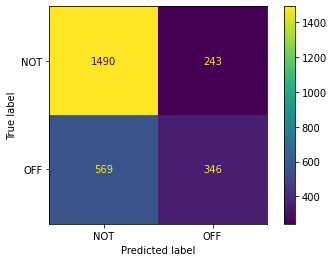

In [187]:
print('Matriz de Confusão - SGDClassifier - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - SGDClassifier - Tarefa B


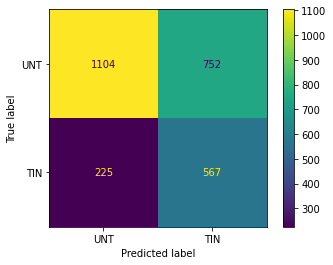

In [188]:
print('Matriz de Confusão - SGDClassifier - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - SGDClassifier- Tarefa A


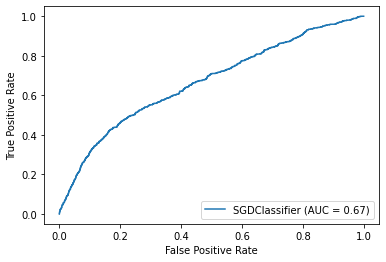

In [189]:
print('Curva ROC - SGDClassifier - Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - SGDClassifier - Tarefa B


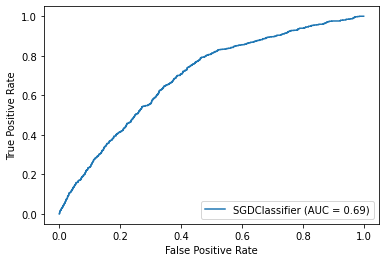

In [190]:
print('Curva ROC - SGDClassifier - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [191]:
scores = cross_val_score(clf_a, X_test_transformed, y_a, cv=10, n_jobs=-1)
print("Pontuação Média - SGDClassifier - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - SGDClassifier - Tarefa A - Cross Validation: 0.68 (+/- 0.12)


In [192]:
scores = cross_val_score(clf_b, X_test_transformed, y_b, cv=10, n_jobs=-1)
print("Pontuação Média - SGDClassifier - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - SGDClassifier - Tarefa B - Cross Validation: 0.68 (+/- 0.16)


---

### RandomForestClassifier

In [193]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='auto',
    min_samples_leaf=5,
    min_samples_split=5,
    n_estimators=200
)

clf_b = clone(clf_a)

In [194]:
print('Relatório de Classificação - RandomForestClassifier - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

y_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, y_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - RandomForestClassifier - Tarefa A
              precision    recall  f1-score   support

         NOT       0.68      0.98      0.80      1733
         OFF       0.74      0.13      0.23       915

    accuracy                           0.68      2648
   macro avg       0.71      0.55      0.51      2648
weighted avg       0.70      0.68      0.60      2648



In [195]:
print('Relatório de Classificação - RandomForestClassifier - Tarefa B')
clf_b.fit(X_train_transformed, yb_train)

y_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, y_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - RandomForestClassifier - Tarefa B
              precision    recall  f1-score   support

         UNT       0.71      0.99      0.83      1856
         TIN       0.74      0.06      0.11       792

    accuracy                           0.71      2648
   macro avg       0.73      0.53      0.47      2648
weighted avg       0.72      0.71      0.62      2648



Matriz de Confusão - RandomForestClassifier - Tarefa A


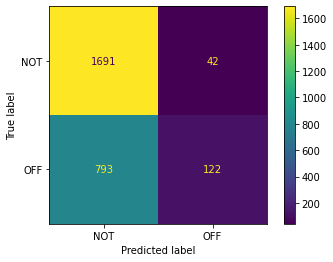

In [196]:
print('Matriz de Confusão - RandomForestClassifier - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - RandomForestClassifier - Tarefa B


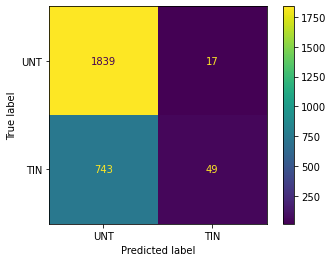

In [197]:
print('Matriz de Confusão - RandomForestClassifier - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - RandomForestClassifier- Tarefa A


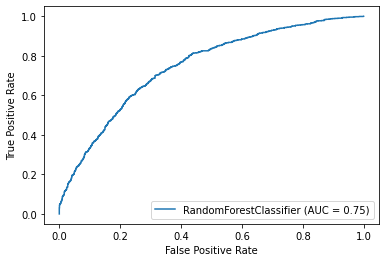

In [198]:
print('Curva ROC - RandomForestClassifier- Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - RandomForestClassifier - Tarefa B


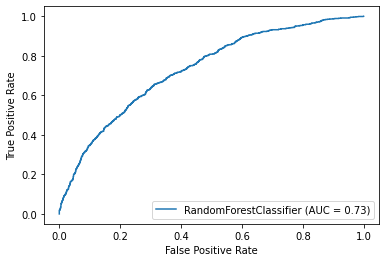

In [199]:
print('Curva ROC - RandomForestClassifier - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [200]:
scores = cross_val_score(clf_a, X_test_transformed, y_a, cv=10, n_jobs=-1)
print("Pontuação Média - RandomForestClassifier - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - RandomForestClassifier - Tarefa A - Cross Validation: 0.70 (+/- 0.02)


In [201]:
scores = cross_val_score(clf_b, X_test_transformed, y_b, cv=10, n_jobs=-1)
print("Pontuação Média - RandomForestClassifier - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - RandomForestClassifier - Tarefa B - Cross Validation: 0.72 (+/- 0.01)


---

### AdaBoostClassifier

In [202]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = AdaBoostClassifier(
    learning_rate=0.1, 
    n_estimators=2000
)

clf_b = clone(clf_a)

In [203]:
print('Relatório de Classificação - AdaBoostClassifier - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

y_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, y_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - AdaBoostClassifier - Tarefa A
              precision    recall  f1-score   support

         NOT       0.72      0.89      0.80      1733
         OFF       0.64      0.36      0.46       915

    accuracy                           0.71      2648
   macro avg       0.68      0.62      0.63      2648
weighted avg       0.69      0.71      0.68      2648



In [204]:
print('Relatório de Classificação - AdaBoostClassifier - Tarefa B')
clf_b.fit(X_train_transformed, yb_train)

y_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, y_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - AdaBoostClassifier - Tarefa B
              precision    recall  f1-score   support

         UNT       0.75      0.91      0.82      1856
         TIN       0.58      0.28      0.38       792

    accuracy                           0.72      2648
   macro avg       0.67      0.60      0.60      2648
weighted avg       0.70      0.72      0.69      2648



Matriz de Confusão - AdaBoostClassifier - Tarefa A


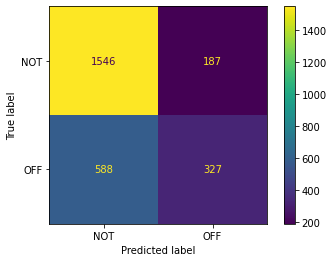

In [205]:
print('Matriz de Confusão - AdaBoostClassifier - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - AdaBoostClassifier - Tarefa B


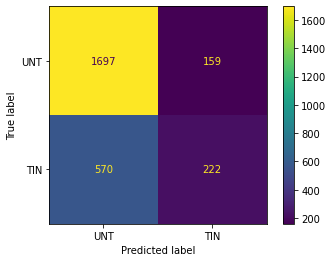

In [206]:
print('Matriz de Confusão - AdaBoostClassifier - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - AdaBoostClassifier- Tarefa A


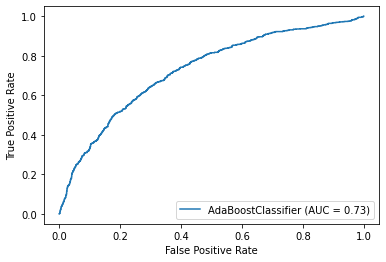

In [207]:
print('Curva ROC - AdaBoostClassifier- Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - AdaBoostClassifier - Tarefa B


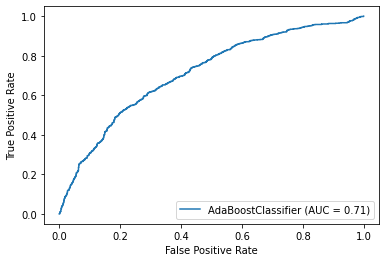

In [208]:
print('Curva ROC - AdaBoostClassifier - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [209]:
scores = cross_val_score(clf_a, X_test_transformed, y_a, cv=10, n_jobs=-1)
print("Pontuação Média - AdaBoostClassifier - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - AdaBoostClassifier - Tarefa A - Cross Validation: 0.72 (+/- 0.02)


In [210]:
scores = cross_val_score(clf_b, X_test_transformed, y_b, cv=10, n_jobs=-1)
print("Pontuação Média - AdaBoostClassifier - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - AdaBoostClassifier - Tarefa B - Cross Validation: 0.73 (+/- 0.02)


----

## Testando os Algoritmos - Feauture "tf-idf" do "unigrama"

In [263]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

models = [
    ('LogisticRegression', LogisticRegression(n_jobs=-1)),
    ('SGDClassifier', SGDClassifier(n_jobs=-1)),
    ('RandomForestClassifier', RandomForestClassifier(n_jobs=-1)),
    ('AdaBoost', AdaBoostClassifier())
]

steps = []
pipelines = []
df_algo_valuation = pd.DataFrame(columns=['Algoritmo', 'Tarefa_A', 'Tarefa_B'])

for name, model in models:
    steps_ = steps.copy()
    steps_.append((f'clf_{name}', model))
    df_algo_valuation = df_algo_valuation.append({'Algoritmo': name, 'Tarefa_A': 0, 'Tarefa_B': 0}, ignore_index=True)
    
    pipelines.append(Pipeline(steps_))

Só utilizando a feature "tf-idf do unigram"

In [ ]:
%%time

X_train, X_test, ya_train, ya_test, yb_train, Yb_test = dataset_split(_tweets)
X_train_transformed = transform_tfidf_column(X_train, 'unigram')
X_test_transformed = transform_tfidf_column(X_test, 'unigram')

# Tarefa A
for idx, pipeline in enumerate(pipelines):
    model_name = pipeline.steps[-1][0].replace('clf_', '')

    pipeline.fit(X_train_transformed, ya_train)
    predicts = pipeline.predict(X_test_transformed)
    
    df_algo_valuation.at[idx, 'Tarefa_A'] = 100 * round(np.mean(predicts == ya_test), 2)
    
# Tarefa B
for idx, pipeline in enumerate(pipelines):
    model_name = pipeline.steps[-1][0].replace('clf_', '')

    pipeline.fit(X_train_transformed, yb_train)
    predicts = pipeline.predict(X_test_transformed)
    
    df_algo_valuation.at[idx, 'Tarefa_B'] = 100 * round(np.mean(predicts == yb_test), 2)

Os algoritmos tiveram um desempenho um pouco melhor na Tarefa B, utilizando apenas a feature "tf-idf do unigram".

In [ ]:
df_algo_valuation.mean()

### Resultado dos Algoritmos

In [ ]:
df_algo_valuation.sort_values('Tarefa_A', ascending=False)

### Métricas

In [267]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = LogisticRegression(
    C=100.0,
    max_iter=500,
    penalty='l2',
    tol=1e-05
)

clf_b = clone(clf_a)

In [268]:
print('Relatório de Classificação - LogisticRegression - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

ya_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, ya_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - LogisticRegression - Tarefa A
              precision    recall  f1-score   support

         NOT       0.77      0.85      0.81      1733
         OFF       0.64      0.52      0.57       915

    accuracy                           0.73      2648
   macro avg       0.70      0.68      0.69      2648
weighted avg       0.72      0.73      0.72      2648



In [269]:
print('Relatório de Classificação - LogisticRegression - Tarefa B')
clf_b.fit(X_train_transformed, yb_train)

yb_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, yb_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - LogisticRegression - Tarefa B
              precision    recall  f1-score   support

         UNT       0.79      0.86      0.82      1856
         TIN       0.58      0.46      0.52       792

    accuracy                           0.74      2648
   macro avg       0.69      0.66      0.67      2648
weighted avg       0.73      0.74      0.73      2648



Matriz de Confusão - LogisticRegression - Tarefa A


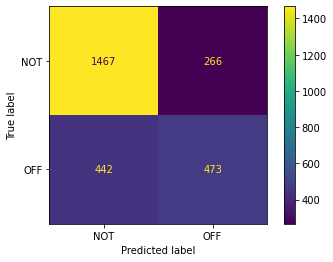

In [270]:
print('Matriz de Confusão - LogisticRegression - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - LogisticRegression - Tarefa B


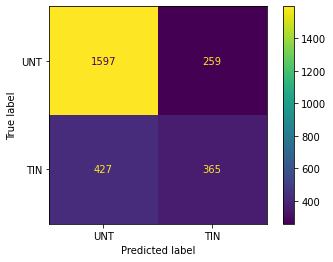

In [271]:
print('Matriz de Confusão - LogisticRegression - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - LogisticRegression- Tarefa A


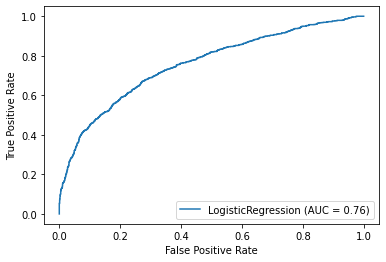

In [272]:
print('Curva ROC - LogisticRegression- Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - LogisticRegression - Tarefa B


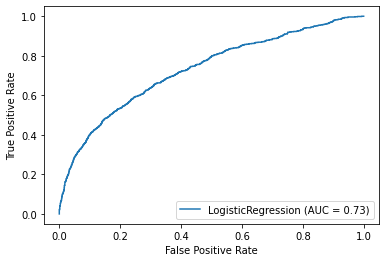

In [273]:
print('Curva ROC - LogisticRegression - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [274]:
scores = cross_val_score(clf_a, X_test_transformed, ya_test, cv=10, n_jobs=-1)
print("Pontuação Média - LogisticRegression - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - LogisticRegression - Tarefa A - Cross Validation: 0.70 (+/- 0.05)


In [275]:
scores = cross_val_score(clf_a, X_test_transformed, yb_test, cv=10, n_jobs=-1)
print("Pontuação Média - LogisticRegression - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - LogisticRegression - Tarefa B - Cross Validation: 0.71 (+/- 0.06)


---

### SGDClassifier

In [276]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = SGDClassifier(
    alpha=0.001,
    loss='hinge',
    max_iter=1000,
    penalty='l1'
)

clf_b = clone(clf_a)

In [277]:
print('Relatório de Classificação - SGDClassifier - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

y_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, ya_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - SGDClassifier - Tarefa A
              precision    recall  f1-score   support

         NOT       0.77      0.85      0.81      1733
         OFF       0.64      0.52      0.57       915

    accuracy                           0.73      2648
   macro avg       0.70      0.68      0.69      2648
weighted avg       0.72      0.73      0.72      2648



In [278]:
print('Relatório de Classificação - SGDClassifier - Tarefa B')
clf_b.fit(X_train_transformed, ya_train)

y_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, yb_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - SGDClassifier - Tarefa B
              precision    recall  f1-score   support

         UNT       0.79      0.86      0.82      1856
         TIN       0.58      0.46      0.52       792

    accuracy                           0.74      2648
   macro avg       0.69      0.66      0.67      2648
weighted avg       0.73      0.74      0.73      2648



Matriz de Confusão - SGDClassifier - Tarefa A


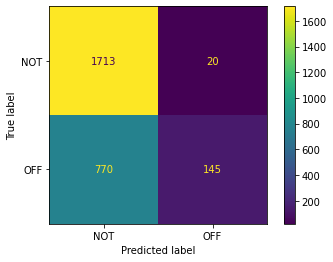

In [279]:
print('Matriz de Confusão - SGDClassifier - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - SGDClassifier - Tarefa B


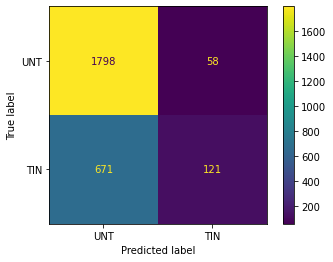

In [280]:
print('Matriz de Confusão - SGDClassifier - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - SGDClassifier - Tarefa A


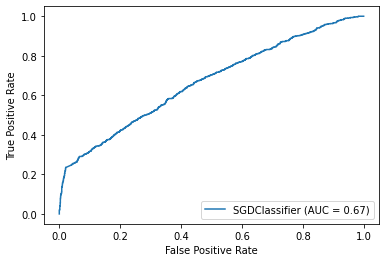

In [281]:
print('Curva ROC - SGDClassifier - Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - SGDClassifier - Tarefa B


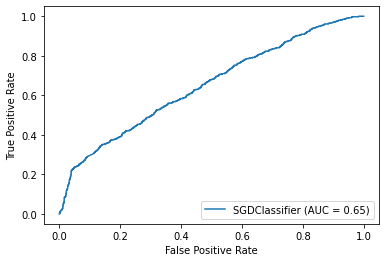

In [282]:
print('Curva ROC - SGDClassifier - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [283]:
scores = cross_val_score(clf_a, X_test_transformed, ya_test, cv=10, n_jobs=-1)
print("Pontuação Média - SGDClassifier - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - SGDClassifier - Tarefa A - Cross Validation: 0.70 (+/- 0.01)


In [284]:
scores = cross_val_score(clf_a, X_test_transformed, yb_test, cv=10, n_jobs=-1)
print("Pontuação Média - SGDClassifier - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - SGDClassifier - Tarefa B - Cross Validation: 0.71 (+/- 0.02)


---

### RandomForestClassifier

In [285]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='auto',
    min_samples_leaf=5,
    min_samples_split=5,
    n_estimators=200
)

clf_b = clone(clf_a)

In [286]:
print('Relatório de Classificação - RandomForestClassifier - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

y_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, y_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - RandomForestClassifier - Tarefa A
              precision    recall  f1-score   support

         NOT       0.66      1.00      0.79      1733
         OFF       1.00      0.01      0.01       915

    accuracy                           0.66      2648
   macro avg       0.83      0.50      0.40      2648
weighted avg       0.77      0.66      0.52      2648



In [287]:
print('Relatório de Classificação - RandomForestClassifier - Tarefa B')
clf_b.fit(X_train_transformed, yb_train)

y_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, y_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - RandomForestClassifier - Tarefa B
              precision    recall  f1-score   support

         UNT       0.70      1.00      0.82      1856
         TIN       1.00      0.00      0.00       792

    accuracy                           0.70      2648
   macro avg       0.85      0.50      0.41      2648
weighted avg       0.79      0.70      0.58      2648



Matriz de Confusão - RandomForestClassifier - Tarefa A


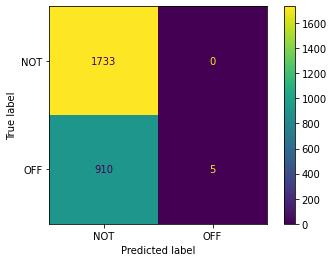

In [288]:
print('Matriz de Confusão - RandomForestClassifier - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - RandomForestClassifier - Tarefa B


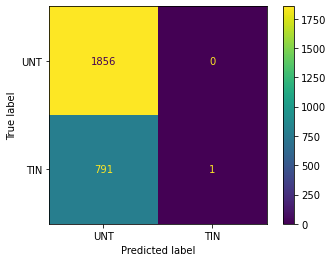

In [289]:
print('Matriz de Confusão - RandomForestClassifier - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - RandomForestClassifier- Tarefa A


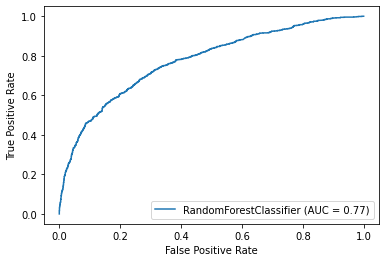

In [290]:
print('Curva ROC - RandomForestClassifier- Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - RandomForestClassifier - Tarefa B


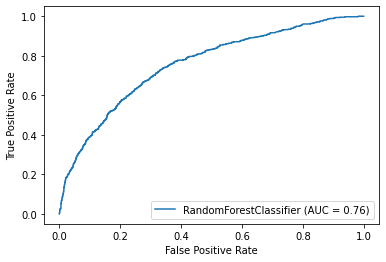

In [291]:
print('Curva ROC - RandomForestClassifier - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [292]:
scores = cross_val_score(clf_a, X_test_transformed, ya_test, cv=10, n_jobs=-1)
print("Pontuação Média - RandomForestClassifier - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - RandomForestClassifier - Tarefa A - Cross Validation: 0.66 (+/- 0.01)


In [293]:
scores = cross_val_score(clf_a, X_test_transformed, yb_test, cv=10, n_jobs=-1)
print("Pontuação Média - RandomForestClassifier - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - RandomForestClassifier - Tarefa B - Cross Validation: 0.70 (+/- 0.00)


---

### AdaBoostClassifier

In [294]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = AdaBoostClassifier(
    learning_rate=0.1, 
    n_estimators=2000
)

clf_b = clone(clf_a)

In [295]:
print('Relatório de Classificação - AdaBoostClassifier - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

y_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, y_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - AdaBoostClassifier - Tarefa A
              precision    recall  f1-score   support

         NOT       0.76      0.94      0.84      1733
         OFF       0.79      0.43      0.56       915

    accuracy                           0.76      2648
   macro avg       0.77      0.69      0.70      2648
weighted avg       0.77      0.76      0.74      2648



In [296]:
print('Relatório de Classificação - AdaBoostClassifier - Tarefa B')
clf_b.fit(X_train_transformed, yb_train)

y_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, y_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - AdaBoostClassifier - Tarefa B
              precision    recall  f1-score   support

         UNT       0.77      0.94      0.84      1856
         TIN       0.70      0.35      0.46       792

    accuracy                           0.76      2648
   macro avg       0.73      0.64      0.65      2648
weighted avg       0.75      0.76      0.73      2648



Matriz de Confusão - AdaBoostClassifier - Tarefa A


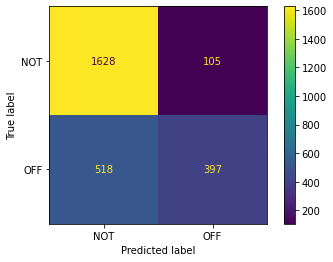

In [297]:
print('Matriz de Confusão - AdaBoostClassifier - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - AdaBoostClassifier - Tarefa B


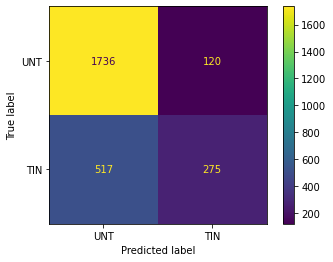

In [298]:
print('Matriz de Confusão - AdaBoostClassifier - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - AdaBoostClassifier- Tarefa A


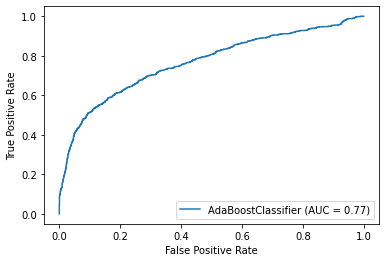

In [299]:
print('Curva ROC - AdaBoostClassifier- Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - AdaBoostClassifier - Tarefa B


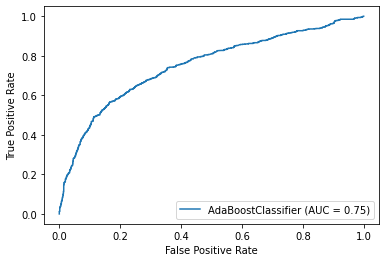

In [300]:
print('Curva ROC - AdaBoostClassifier - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [301]:
scores = cross_val_score(clf_a, X_test_transformed, ya_test, cv=10, n_jobs=-1)
print("Pontuação Média - AdaBoostClassifier - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - AdaBoostClassifier - Tarefa A - Cross Validation: 0.71 (+/- 0.04)


In [302]:
scores = cross_val_score(clf_a, X_test_transformed, yb_test, cv=10, n_jobs=-1)
print("Pontuação Média - AdaBoostClassifier - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - AdaBoostClassifier - Tarefa B - Cross Validation: 0.72 (+/- 0.04)


---

## Testando os Algoritmos - Feauture "tf-idf" do "bigrama"

In [252]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

models = [
    ('LogisticRegression', LogisticRegression(n_jobs=-1))
]

steps = []
pipelines = []
df_algo_valuation = pd.DataFrame(columns=['Algoritmo', 'Tarefa_A', 'Tarefa_B'])

for name, model in models:
    steps_ = steps.copy()
    steps_.append((f'clf_{name}', model))
    df_algo_valuation = df_algo_valuation.append({'Algoritmo': name, 'Tarefa_A': 0, 'Tarefa_B': 0}, ignore_index=True)
    
    pipelines.append(Pipeline(steps_))

Só utilizando a feature "tf-idf do bigrama"

In [253]:
%env JOBLIB_TEMP_FOLDER=/tmp

X_train, X_test, ya_train, ya_test, yb_train, yb_test = dataset_split(_tweets)
X_transformed = transform_tfidf_column(X_train, 'bigram')

# Tarefa A
for idx, pipeline in enumerate(pipelines):
    model_name = pipeline.steps[-1][0].replace('clf_', '')

    pipeline.fit(X_transformed, ya_train)
    predicts = pipeline.predict(transform_tfidf_column(X_test, 'bigram'))
    
    df_algo_valuation.at[idx, 'Tarefa_A'] = 100 * round(np.mean(predicts == ya_test), 2)

env: JOBLIB_TEMP_FOLDER=/tmp


In [254]:
df_algo_valuation.mean()

Tarefa_A    66.0
Tarefa_B     0.0
dtype: float64

### Resultado dos Algoritmos

In [255]:
df_algo_valuation.sort_values('Tarefa_A', ascending=False)

,Algoritmo,Tarefa_A,Tarefa_B
0,LogisticRegression,66,0


Iremos ignorar a feature tf-idf do Bigrama, <b>pois é muito lento e pouco eficiente</b>. Cada tweet (instância) possui <b>126373 features</b>. Teria que usar uma redução de dimensionalidade para diminuir a quantidade de features.  

## Testando os Algoritmos - Feauture "embedding" e "pos"

In [350]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

models = [
    ('LogisticRegression', LogisticRegression(n_jobs=-1)),
    ('SGDClassifier', SGDClassifier(n_jobs=-1)),
    ('RandomForestClassifier', RandomForestClassifier(n_jobs=-1)),
    ('AdaBoost', AdaBoostClassifier())
]

steps = []
pipelines = []
df_algo_valuation = pd.DataFrame(columns=['Algoritmo', 'Tarefa_A', 'Tarefa_B'])

for name, model in models:
    steps_ = steps.copy()
    steps_.append((f'clf_{name}', model))
    df_algo_valuation = df_algo_valuation.append({'Algoritmo': name, 'Tarefa_A': 0, 'Tarefa_B': 0}, ignore_index=True)
    
    pipelines.append(Pipeline(steps_))

In [354]:
%%time

# Treino
X_train, X_test, ya_train, ya_test, yb_train, Yb_test = dataset_split(_tweets)
X_train_embedding_transformed = transform_embedding_column(X_train)
X_train_pos_transformed = transform_pos_column(X_train)
X_train_transformed = np.concatenate([X_train_embedding_transformed, X_train_pos_transformed], axis=1)

# Teste
X_test_embedding_transformed = transform_embedding_column(X_test)
X_test_pos_transformed = transform_pos_column(X_test)
X_test_transformed = np.concatenate([X_test_embedding_transformed, X_test_pos_transformed], axis=1)


# Tarefa A
for idx, pipeline in enumerate(pipelines):
    model_name = pipeline.steps[-1][0].replace('clf_', '')

    pipeline.fit(X_train_transformed[:1000], ya_train[:1000])
    predicts = pipeline.predict(X_test_transformed[:1000])
    df_algo_valuation.at[idx, 'Tarefa_A'] = 100 * round(np.mean(predicts == ya_test), 2)
    
# Tarefa B
for idx, pipeline in enumerate(pipelines):
    model_name = pipeline.steps[-1][0].replace('clf_', '')

    pipeline.fit(X_train_transformed[:200], yb_train[:200])
    predicts = pipeline.predict(X_test_transformed[:200])    
    df_algo_valuation.at[idx, 'Tarefa_B'] = 100 * round(np.mean(predicts == yb_test), 2)

CPU times: user 4.23 s, sys: 384 ms, total: 4.61 s
Wall time: 4.66 s


In [355]:
df_algo_valuation.mean()

Tarefa_A    0.0
Tarefa_B    0.0
dtype: float64

### Resultado dos Algoritmos

In [356]:
df_algo_valuation.sort_values('Tarefa_A', ascending=False)

,Algoritmo,Tarefa_A,Tarefa_B
0,LogisticRegression,0,0


### Métricas

In [306]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = LogisticRegression(
    C=100.0,
    max_iter=500,
    penalty='l2',
    tol=1e-05
)

clf_b = clone(clf_a)

In [307]:
print('Relatório de Classificação - LogisticRegression - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

ya_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, ya_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - LogisticRegression - Tarefa A
              precision    recall  f1-score   support

         NOT       0.71      0.91      0.80      1733
         OFF       0.63      0.28      0.39       915

    accuracy                           0.69      2648
   macro avg       0.67      0.60      0.59      2648
weighted avg       0.68      0.69      0.66      2648



In [308]:
print('Relatório de Classificação - LogisticRegression - Tarefa B')
clf_b.fit(X_train_transformed, yb_train)

yb_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, yb_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - LogisticRegression - Tarefa B
              precision    recall  f1-score   support

         UNT       0.73      0.91      0.81      1856
         TIN       0.53      0.22      0.31       792

    accuracy                           0.71      2648
   macro avg       0.63      0.57      0.56      2648
weighted avg       0.67      0.71      0.66      2648



Matriz de Confusão - LogisticRegression - Tarefa A


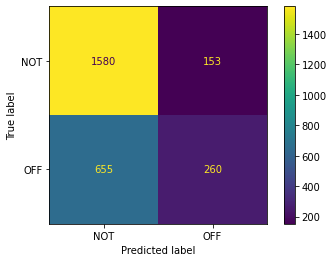

In [309]:
print('Matriz de Confusão - LogisticRegression - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - LogisticRegression - Tarefa B


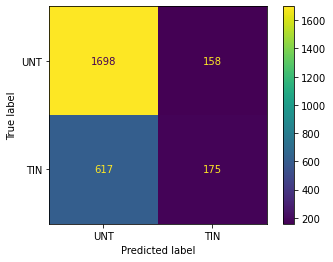

In [310]:
print('Matriz de Confusão - LogisticRegression - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - LogisticRegression- Tarefa A


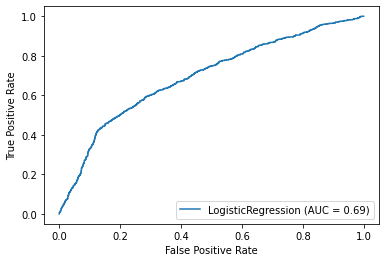

In [311]:
print('Curva ROC - LogisticRegression - Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - LogisticRegression - Tarefa B


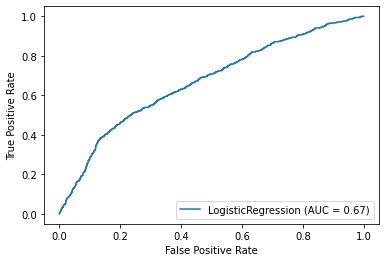

In [312]:
print('Curva ROC - LogisticRegression - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [313]:
scores = cross_val_score(clf_a, X_test_transformed, ya_test, cv=10, n_jobs=-1)
print("Pontuação Média - LogisticRegression - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - LogisticRegression - Tarefa A - Cross Validation: 0.69 (+/- 0.03)


In [314]:
scores = cross_val_score(clf_a, X_test_transformed, yb_test, cv=10, n_jobs=-1)
print("Pontuação Média - LogisticRegression - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - LogisticRegression - Tarefa B - Cross Validation: 0.71 (+/- 0.03)


---

### SGDClassifier

In [315]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = SGDClassifier(
    alpha=0.001,
    loss='hinge',
    max_iter=1000,
    penalty='l1'
)

clf_b = clone(clf_a)

In [316]:
print('Relatório de Classificação - SGDClassifier - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

y_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, ya_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - SGDClassifier - Tarefa A
              precision    recall  f1-score   support

         NOT       0.71      0.91      0.80      1733
         OFF       0.63      0.28      0.39       915

    accuracy                           0.69      2648
   macro avg       0.67      0.60      0.59      2648
weighted avg       0.68      0.69      0.66      2648



In [317]:
print('Relatório de Classificação - SGDClassifier - Tarefa B')
clf_b.fit(X_train_transformed, ya_train)

y_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, yb_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - SGDClassifier - Tarefa B
              precision    recall  f1-score   support

         UNT       0.73      0.91      0.81      1856
         TIN       0.53      0.22      0.31       792

    accuracy                           0.71      2648
   macro avg       0.63      0.57      0.56      2648
weighted avg       0.67      0.71      0.66      2648



Matriz de Confusão - SGDClassifier - Tarefa A


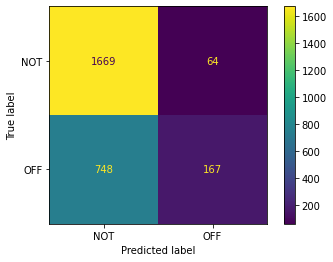

In [318]:
print('Matriz de Confusão - SGDClassifier - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - SGDClassifier - Tarefa B


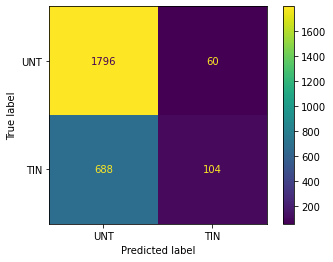

In [319]:
print('Matriz de Confusão - SGDClassifier - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - SGDClassifier - Tarefa A


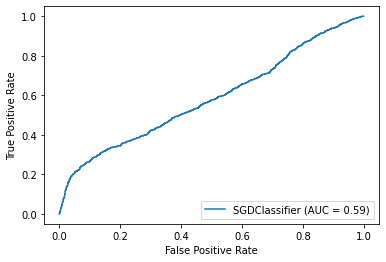

In [320]:
print('Curva ROC - SGDClassifier - Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - SGDClassifier - Tarefa B


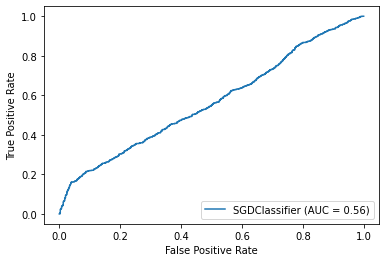

In [321]:
print('Curva ROC - SGDClassifier - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [322]:
scores = cross_val_score(clf_a, X_test_transformed, ya_test, cv=10, n_jobs=-1)
print("Pontuação Média - SGDClassifier - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - SGDClassifier - Tarefa A - Cross Validation: 0.64 (+/- 0.19)


In [323]:
scores = cross_val_score(clf_a, X_test_transformed, yb_test, cv=10, n_jobs=-1)
print("Pontuação Média - SGDClassifier - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - SGDClassifier - Tarefa B - Cross Validation: 0.59 (+/- 0.26)


---

### RandomForestClassifier

In [324]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='auto',
    min_samples_leaf=5,
    min_samples_split=5,
    n_estimators=200
)

clf_b = clone(clf_a)

In [325]:
print('Relatório de Classificação - RandomForestClassifier - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

y_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, y_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - RandomForestClassifier - Tarefa A
              precision    recall  f1-score   support

         NOT       0.68      0.98      0.80      1733
         OFF       0.79      0.13      0.22       915

    accuracy                           0.69      2648
   macro avg       0.73      0.55      0.51      2648
weighted avg       0.72      0.69      0.60      2648



In [326]:
print('Relatório de Classificação - RandomForestClassifier - Tarefa B')
clf_b.fit(X_train_transformed, yb_train)

y_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, y_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - RandomForestClassifier - Tarefa B
              precision    recall  f1-score   support

         UNT       0.71      0.99      0.83      1856
         TIN       0.71      0.05      0.10       792

    accuracy                           0.71      2648
   macro avg       0.71      0.52      0.46      2648
weighted avg       0.71      0.71      0.61      2648



Matriz de Confusão - RandomForestClassifier - Tarefa A


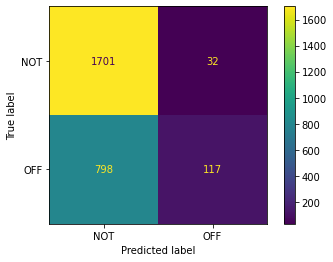

In [327]:
print('Matriz de Confusão - RandomForestClassifier - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - RandomForestClassifier - Tarefa B


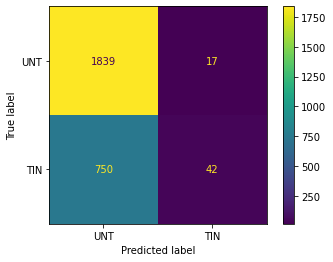

In [328]:
print('Matriz de Confusão - RandomForestClassifier - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - RandomForestClassifier- Tarefa A


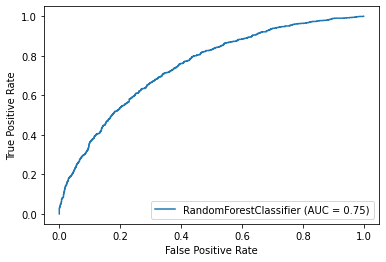

In [329]:
print('Curva ROC - RandomForestClassifier- Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - RandomForestClassifier - Tarefa B


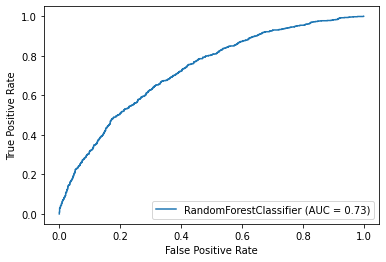

In [330]:
print('Curva ROC - RandomForestClassifier - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [331]:
scores = cross_val_score(clf_a, X_test_transformed, ya_test, cv=10, n_jobs=-1)
print("Pontuação Média - RandomForestClassifier - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - RandomForestClassifier - Tarefa A - Cross Validation: 0.68 (+/- 0.03)


In [332]:
scores = cross_val_score(clf_a, X_test_transformed, yb_test, cv=10, n_jobs=-1)
print("Pontuação Média - RandomForestClassifier - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - RandomForestClassifier - Tarefa B - Cross Validation: 0.71 (+/- 0.02)


---

### AdaBoostClassifier

In [333]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = AdaBoostClassifier(
    learning_rate=0.1, 
    n_estimators=2000
)

clf_b = clone(clf_a)

In [334]:
print('Relatório de Classificação - AdaBoostClassifier - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

y_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, y_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - AdaBoostClassifier - Tarefa A
              precision    recall  f1-score   support

         NOT       0.72      0.89      0.80      1733
         OFF       0.63      0.35      0.45       915

    accuracy                           0.70      2648
   macro avg       0.67      0.62      0.62      2648
weighted avg       0.69      0.70      0.68      2648



In [335]:
print('Relatório de Classificação - AdaBoostClassifier - Tarefa B')
clf_b.fit(X_train_transformed, yb_train)

y_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, y_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - AdaBoostClassifier - Tarefa B
              precision    recall  f1-score   support

         UNT       0.75      0.92      0.83      1856
         TIN       0.59      0.28      0.38       792

    accuracy                           0.73      2648
   macro avg       0.67      0.60      0.60      2648
weighted avg       0.70      0.73      0.69      2648



Matriz de Confusão - AdaBoostClassifier - Tarefa A


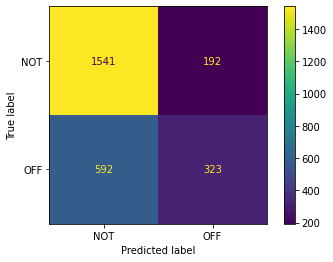

In [336]:
print('Matriz de Confusão - AdaBoostClassifier - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - AdaBoostClassifier - Tarefa B


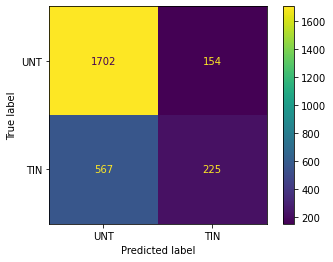

In [337]:
print('Matriz de Confusão - AdaBoostClassifier - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - AdaBoostClassifier- Tarefa A


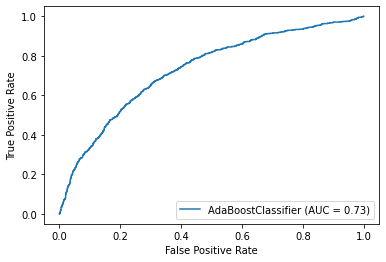

In [338]:
print('Curva ROC - AdaBoostClassifier- Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - AdaBoostClassifier - Tarefa B


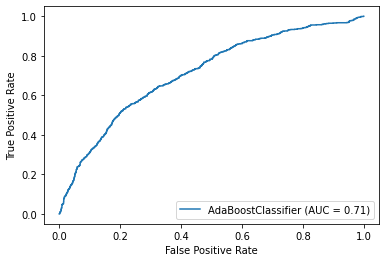

In [339]:
print('Curva ROC - AdaBoostClassifier - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [340]:
scores = cross_val_score(clf_a, X_test_transformed, ya_test, cv=10, n_jobs=-1)
print("Pontuação Média - AdaBoostClassifier - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - AdaBoostClassifier - Tarefa A - Cross Validation: 0.68 (+/- 0.04)


In [341]:
scores = cross_val_score(clf_a, X_test_transformed, yb_test, cv=10, n_jobs=-1)
print("Pontuação Média - AdaBoostClassifier - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - AdaBoostClassifier - Tarefa B - Cross Validation: 0.71 (+/- 0.03)


---

## Testando os Algoritmos - Feauture "embedding", "pos" e "tf-idf unigrama" 

In [378]:
%%time

X_train, X_test, ya_train, ya_test, yb_train, Yb_test = dataset_split(_tweets)

# Treino
X_train_embedding_transformed = transform_embedding_column(X_train)
X_train_pos_transformed = transform_pos_column(X_train)
X_train_tfidf_transformed = transform_tfidf_column(X_train, 'unigram')
X_train_transformed = np.concatenate([X_train_embedding_transformed, X_train_pos_transformed, X_train_tfidf_transformed], axis=1)

# Teste
X_test_embedding_transformed = transform_embedding_column(X_test)
X_test_pos_transformed = transform_pos_column(X_test)
X_test_tfidf_transformed = transform_tfidf_column(X_test, 'unigram')
X_test_transformed = np.concatenate([X_test_embedding_transformed, X_test_pos_transformed, X_test_tfidf_transformed], axis=1)


# Tarefa A
for idx, pipeline in enumerate(pipelines):
    model_name = pipeline.steps[-1][0].replace('clf_', '')

    pipeline.fit(X_train_transformed, ya_train)
    predicts = pipeline.predict(X_test_transformed)
    df_algo_valuation.at[idx, 'Tarefa_A'] = 100 * round(np.mean(predicts == ya_test), 2)
    
# Tarefa B
for idx, pipeline in enumerate(pipelines):
    model_name = pipeline.steps[-1][0].replace('clf_', '')

    pipeline.fit(X_train_transformed, yb_train)
    predicts = pipeline.predict(X_test_transformed)
    df_algo_valuation.at[idx, 'Tarefa_B'] = 100 * round(np.mean(predicts == yb_test), 2)

CPU times: user 4.97 s, sys: 832 ms, total: 5.8 s
Wall time: 5.8 s


In [360]:
df_algo_valuation.mean()

Tarefa_A    0.0
Tarefa_B    0.0
dtype: float64

### Resultado dos Algoritmos

In [361]:
df_algo_valuation.sort_values('Tarefa_A', ascending=False)

,Algoritmo,Tarefa_A,Tarefa_B
0,LogisticRegression,0,0


### Métricas

In [379]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = LogisticRegression(
    C=100.0,
    max_iter=500,
    penalty='l2',
    tol=1e-05
)

clf_b = clone(clf_a)

In [381]:
print('Relatório de Classificação - LogisticRegression - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

ya_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, ya_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - LogisticRegression - Tarefa A
              precision    recall  f1-score   support

         NOT       0.71      0.91      0.80      1733
         OFF       0.63      0.29      0.40       915

    accuracy                           0.69      2648
   macro avg       0.67      0.60      0.60      2648
weighted avg       0.68      0.69      0.66      2648



In [382]:
print('Relatório de Classificação - LogisticRegression - Tarefa B')
clf_b.fit(X_train_transformed, yb_train)

yb_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, yb_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - LogisticRegression - Tarefa B
              precision    recall  f1-score   support

         UNT       0.73      0.93      0.82      1856
         TIN       0.54      0.20      0.29       792

    accuracy                           0.71      2648
   macro avg       0.63      0.56      0.55      2648
weighted avg       0.67      0.71      0.66      2648



Matriz de Confusão - LogisticRegression - Tarefa A


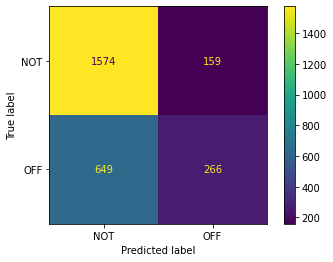

In [383]:
print('Matriz de Confusão - LogisticRegression - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - LogisticRegression - Tarefa B


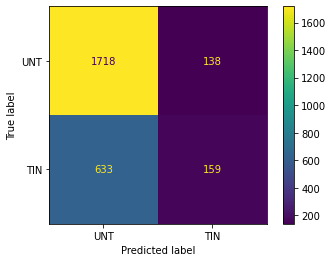

In [384]:
print('Matriz de Confusão - LogisticRegression - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - LogisticRegression- Tarefa A


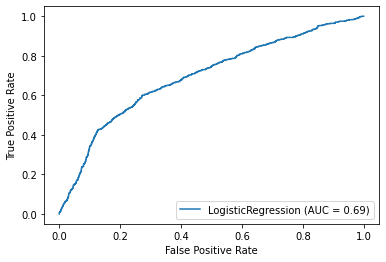

In [385]:
print('Curva ROC - LogisticRegression- Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - LogisticRegression - Tarefa B


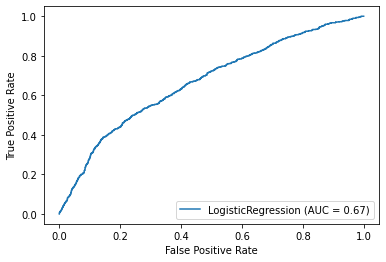

In [386]:
print('Curva ROC - LogisticRegression - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [387]:
scores = cross_val_score(clf_a, X_test_transformed, ya_test, cv=10, n_jobs=-1)
print("Pontuação Média - LogisticRegression - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - LogisticRegression - Tarefa A - Cross Validation: 0.69 (+/- 0.03)


In [388]:
scores = cross_val_score(clf_a, X_test_transformed, yb_test, cv=10, n_jobs=-1)
print("Pontuação Média - LogisticRegression - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - LogisticRegression - Tarefa B - Cross Validation: 0.71 (+/- 0.03)


---

### SGDClassifier

In [389]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = SGDClassifier(
    alpha=0.001,
    loss='hinge',
    max_iter=1000,
    penalty='l1'
)

clf_b = clone(clf_a)

In [390]:
print('Relatório de Classificação - SGDClassifier - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

y_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, ya_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - SGDClassifier - Tarefa A
              precision    recall  f1-score   support

         NOT       0.71      0.91      0.80      1733
         OFF       0.63      0.29      0.40       915

    accuracy                           0.69      2648
   macro avg       0.67      0.60      0.60      2648
weighted avg       0.68      0.69      0.66      2648



In [391]:
print('Relatório de Classificação - SGDClassifier - Tarefa B')
clf_b.fit(X_train_transformed, ya_train)

y_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, yb_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - SGDClassifier - Tarefa B
              precision    recall  f1-score   support

         UNT       0.73      0.93      0.82      1856
         TIN       0.54      0.20      0.29       792

    accuracy                           0.71      2648
   macro avg       0.63      0.56      0.55      2648
weighted avg       0.67      0.71      0.66      2648



Matriz de Confusão - SGDClassifier - Tarefa A


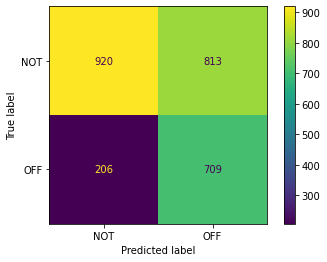

In [392]:
print('Matriz de Confusão - SGDClassifier - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - SGDClassifier - Tarefa B


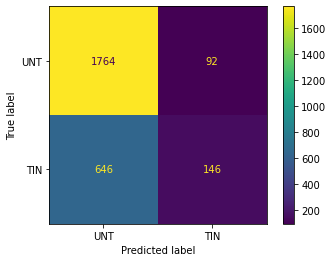

In [393]:
print('Matriz de Confusão - SGDClassifier - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - SGDClassifier - Tarefa A


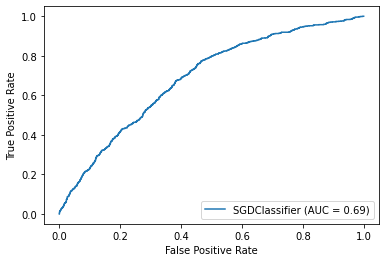

In [394]:
print('Curva ROC - SGDClassifier - Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - SGDClassifier - Tarefa B


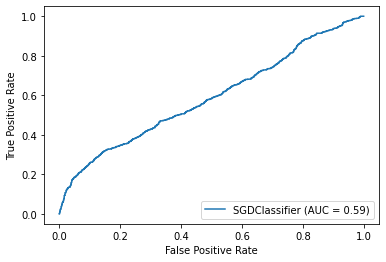

In [395]:
print('Curva ROC - SGDClassifier - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [396]:
scores = cross_val_score(clf_a, X_test_transformed, ya_test, cv=10, n_jobs=-1)
print("Pontuação Média - SGDClassifier - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - SGDClassifier - Tarefa A - Cross Validation: 0.63 (+/- 0.14)


In [397]:
scores = cross_val_score(clf_a, X_test_transformed, yb_test, cv=10, n_jobs=-1)
print("Pontuação Média - SGDClassifier - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - SGDClassifier - Tarefa B - Cross Validation: 0.70 (+/- 0.02)


---

### RandomForestClassifier

In [398]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='auto',
    min_samples_leaf=5,
    min_samples_split=5,
    n_estimators=200
)

clf_b = clone(clf_a)

In [399]:
print('Relatório de Classificação - RandomForestClassifier - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

y_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, y_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - RandomForestClassifier - Tarefa A
              precision    recall  f1-score   support

         NOT       0.66      1.00      0.79      1733
         OFF       1.00      0.02      0.03       915

    accuracy                           0.66      2648
   macro avg       0.83      0.51      0.41      2648
weighted avg       0.78      0.66      0.53      2648



In [400]:
print('Relatório de Classificação - RandomForestClassifier - Tarefa B')
clf_b.fit(X_train_transformed, yb_train)

y_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, y_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - RandomForestClassifier - Tarefa B
              precision    recall  f1-score   support

         UNT       0.70      1.00      0.82      1856
         TIN       1.00      0.00      0.00       792

    accuracy                           0.70      2648
   macro avg       0.85      0.50      0.41      2648
weighted avg       0.79      0.70      0.58      2648



Matriz de Confusão - RandomForestClassifier - Tarefa A


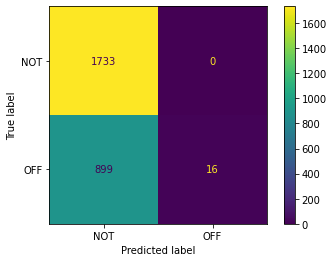

In [401]:
print('Matriz de Confusão - RandomForestClassifier - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - RandomForestClassifier - Tarefa B


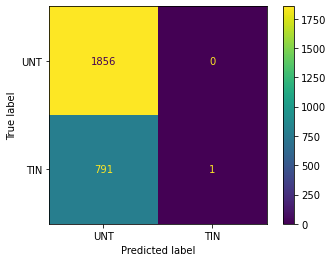

In [402]:
print('Matriz de Confusão - RandomForestClassifier - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - RandomForestClassifier- Tarefa A


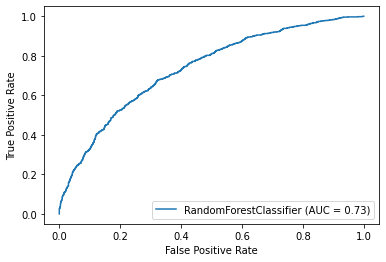

In [403]:
print('Curva ROC - RandomForestClassifier- Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - RandomForestClassifier - Tarefa B


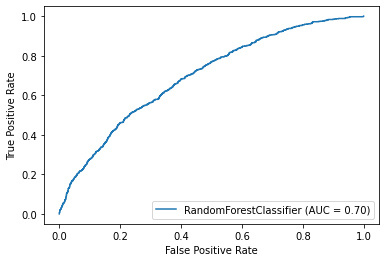

In [404]:
print('Curva ROC - RandomForestClassifier - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [405]:
scores = cross_val_score(clf_a, X_test_transformed, ya_test, cv=10, n_jobs=-1)
print("Pontuação Média - RandomForestClassifier - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - RandomForestClassifier - Tarefa A - Cross Validation: 0.66 (+/- 0.01)


In [406]:
scores = cross_val_score(clf_a, X_test_transformed, yb_test, cv=10, n_jobs=-1)
print("Pontuação Média - RandomForestClassifier - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - RandomForestClassifier - Tarefa B - Cross Validation: 0.70 (+/- 0.00)


---

### AdaBoostClassifier

In [407]:
# Parametros escolhidos pelo hyperparameter optimization
clf_a = AdaBoostClassifier(
    learning_rate=0.1, 
    n_estimators=2000
)

clf_b = clone(clf_a)

In [408]:
print('Relatório de Classificação - AdaBoostClassifier - Tarefa A')
clf_a.fit(X_train_transformed, ya_train)

y_pred = clf_a.predict(X_test_transformed)
print(classification_report(ya_test, y_pred, labels=[0,1], target_names=['NOT', 'OFF']))

Relatório de Classificação - AdaBoostClassifier - Tarefa A
              precision    recall  f1-score   support

         NOT       0.76      0.92      0.83      1733
         OFF       0.75      0.46      0.57       915

    accuracy                           0.76      2648
   macro avg       0.76      0.69      0.70      2648
weighted avg       0.76      0.76      0.74      2648



In [409]:
print('Relatório de Classificação - AdaBoostClassifier - Tarefa B')
clf_b.fit(X_train_transformed, yb_train)

y_pred = clf_b.predict(X_test_transformed)
print(classification_report(yb_test, y_pred, labels=[0,1], target_names=['UNT', 'TIN']))

Relatório de Classificação - AdaBoostClassifier - Tarefa B
              precision    recall  f1-score   support

         UNT       0.77      0.92      0.84      1856
         TIN       0.66      0.35      0.46       792

    accuracy                           0.75      2648
   macro avg       0.71      0.64      0.65      2648
weighted avg       0.74      0.75      0.73      2648



Matriz de Confusão - AdaBoostClassifier - Tarefa A


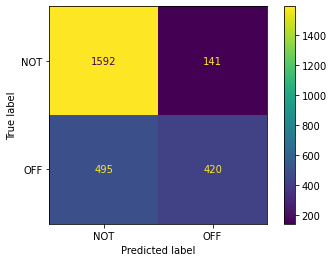

In [410]:
print('Matriz de Confusão - AdaBoostClassifier - Tarefa A')
plot_confusion_matrix(clf_a, X_test_transformed, ya_test, display_labels=['NOT', 'OFF'])

Matriz de Confusão - AdaBoostClassifier - Tarefa B


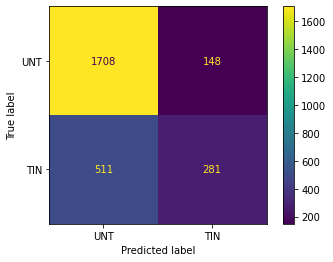

In [411]:
print('Matriz de Confusão - AdaBoostClassifier - Tarefa B')
plot_confusion_matrix(clf_b, X_test_transformed, yb_test, display_labels=['UNT', 'TIN'])

Curva ROC - AdaBoostClassifier- Tarefa A


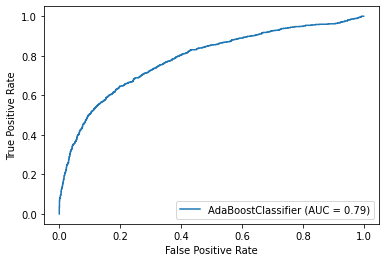

In [412]:
print('Curva ROC - AdaBoostClassifier - Tarefa A')
plot_roc_curve(clf_a, X_test_transformed, ya_test)

Curva ROC - AdaBoostClassifier - Tarefa B


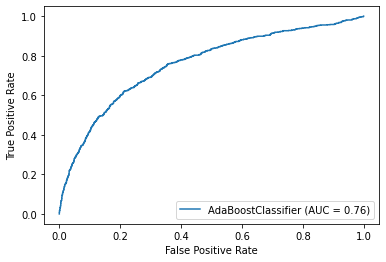

In [413]:
print('Curva ROC - AdaBoostClassifier - Tarefa B')
plot_roc_curve(clf_b, X_test_transformed, yb_test)

In [414]:
scores = cross_val_score(clf_a, X_test_transformed, ya_test, cv=10, n_jobs=-1)
print("Pontuação Média - AdaBoostClassifier - Tarefa A - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - AdaBoostClassifier - Tarefa A - Cross Validation: 0.70 (+/- 0.06)


In [415]:
scores = cross_val_score(clf_a, X_test_transformed, yb_test, cv=10, n_jobs=-1)
print("Pontuação Média - AdaBoostClassifier - Tarefa B - Cross Validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Pontuação Média - AdaBoostClassifier - Tarefa B - Cross Validation: 0.71 (+/- 0.05)


---

# Resultados Finais

<div>
    O classificador escolhido foi o <span style='font-size: 20px;'><b>AdaBoostClassifier</b></span>.
<br><br>
As features utilizadas foram  <span style='font-size: 18px;'><b>"embedding", "pos" e "tf-idf unigrama"</b></span>.
</div>

## Gráficos

### Tarefa A

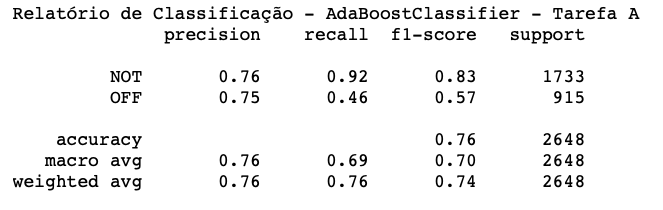

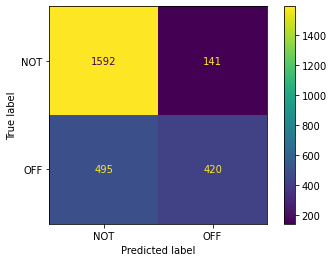

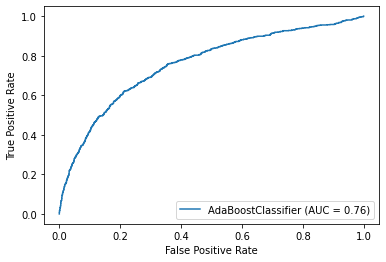

### Tarefa B

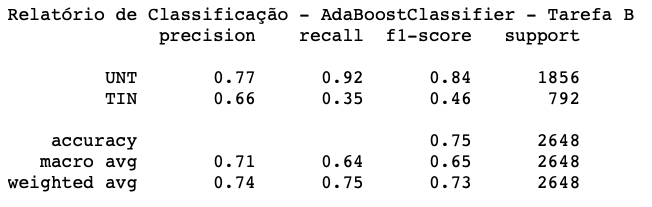

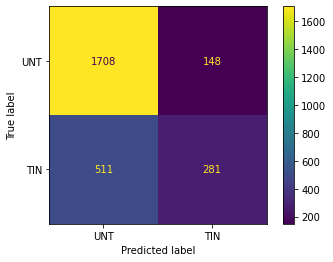

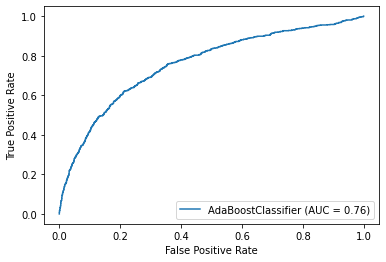

## Exportando Resultados

In [5]:
PATH = os.path.join(os.getcwd(), 'datasets')

TASK_A_TEST_SET = os.path.join(PATH, 'testset-levela.tsv')
TASK_B_TEST_SET = os.path.join(PATH, 'testset-levelb.tsv')

In [6]:
task_a = pd.read_csv(TASK_A_TEST_SET, sep='\t')
task_b = pd.read_csv(TASK_B_TEST_SET, sep='\t')

In [7]:
task_a.head()

,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,27014,"#ConstitutionDay is revered by Conservatives, ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,13876,#Watching #Boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...


In [142]:
task_b.head()

,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,60133,#NoPasaran: Unity demo to oppose the far-right...
2,83681,. . . What the fuck did he do this time?
3,65507,@USER Do you get the feeling he is kissing @US...
4,12588,@USER Nigga ware da hits at


In [9]:
clf_a_f = load('clf_a_f.joblib')
clf_b_f = load('clf_b_f.joblib')

In [105]:
# Normalizando e buscando as features.
# Esqueci de salvar o pipeline "treinado"
X = [t['tweet'] for t in tweets]

pipeline = Pipeline([
    ('normalize', TweetNormalizer()),
    ('featurize', TweetFeaturizer())
])

pipeline.fit(X)

__ = list(pipeline.transform(X))

### Tarefa A

In [112]:
_X = list(pipeline.transform(task_a['tweet'].values))

X_A_embedding_transformed = transform_embedding_column(_X)
X_A_pos_transformed = transform_pos_column(_X)
X_A_tfidf_transformed = transform_tfidf_column(_X, 'unigram')
X_A_transformed = np.concatenate([X_A_embedding_transformed, X_A_pos_transformed, X_A_tfidf_transformed], axis=1)

In [113]:
ya_pred = clf_a_f.predict(X_A_transformed)

In [128]:
task_a_res = pd.DataFrame(zip(task_a['id'].values, ['NOT' if y == 0 else 'OFF' for y in ya_pred]), columns=['id', 'subtask_a'])

In [139]:
pd.DataFrame.to_csv(task_a_res, path_or_buf='grupo4_subtaskA.csv', sep=',', index=False)

### Tarefa B

In [117]:
_X = list(pipeline.transform(task_b['tweet'].values))

X_B_embedding_transformed = transform_embedding_column(_X)
X_B_pos_transformed = transform_pos_column(_X)
X_B_tfidf_transformed = transform_tfidf_column(_X, 'unigram')
X_B_transformed = np.concatenate([X_B_embedding_transformed, X_B_pos_transformed, X_B_tfidf_transformed], axis=1)

In [118]:
yb_pred = clf_b_f.predict(X_B_transformed)

In [126]:
task_b_res = pd.DataFrame(zip(task_b['id'].values, ['UNT' if y == 0 else 'TIN' for y in yb_pred]), columns=['id', 'subtask_b'])

In [140]:
pd.DataFrame.to_csv(task_b_res, path_or_buf='grupo4_subtaskB.csv', sep=',', index=False)

# Projetos Futuros
- Balancear o dataset (deixar a mesma quantidade de OFF/NOT e TIN/UNT
- Utilizar o BERT